In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette('Dark2')
sns.set_style({'axes.axisbelow': True, 'axes.edgecolor': '.15', 'axes.facecolor': 'white',
               'axes.grid': True, 'axes.labelcolor': '.15', 'axes.linewidth': 1.25, 
               'figure.facecolor': 'white', 'font.family': ['sans-serif'], 'grid.color': '.15',
               'grid.linestyle': ':', 'grid.alpha': .5, 'image.cmap': 'Greys', 
               'legend.frameon': False, 'legend.numpoints': 1, 'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'round', 'axes.spines.right': False, 'axes.spines.top': False,  
               'text.color': '.15',  'xtick.top': False, 'ytick.right': False, 'xtick.color': '.15',
               'xtick.direction': 'out', 'xtick.major.size': 6, 'xtick.minor.size': 3,
               'ytick.color': '.15', 'ytick.direction': 'out', 'ytick.major.size': 6,'ytick.minor.size': 3})
sns.set_context('paper')

#http://phyletica.org/matplotlib-fonts/
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
from snapanalysis.config import OUTPUT_DIRECTORY as MAIN_OUTPUT_DIRECTORY
OUTPUT_DIRECTORY = os.path.join(MAIN_OUTPUT_DIRECTORY, 'ptm-response')

if not os.path.isdir(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

In [3]:
from snapanalysis.models.ptm_response.main import OUTPUT_FILE as PTM_RESPONSE_FILE

from snapanalysis.models.ptm_response.main import PREDICTOR_ORDER
predictors = PREDICTOR_ORDER

limma_results = pd.read_hdf(PTM_RESPONSE_FILE, '/ptm_stats/joint_limma_stats')
predictors_from_limma = limma_results.reset_index()['predictor'].unique()
assert all(p in predictors_from_limma for p in predictors)
assert all(p in predictors for p in predictors_from_limma)

with pd.HDFStore(PTM_RESPONSE_FILE, 'r') as store: 
    enrichment_complexes = store['/ptm_stats/joint_camera_complexes']
    joint_limma_stats = store['/ptm_stats/joint_limma_stats']
    

In [4]:
GROUPED_ORDER = [
    ['H2A.Z', 'DNA Methylation'],
    
    ['H3K4me1', 'H3K4me3'],
    ['H3ac', 'H3K9acK14ac', 'H3K27ac'],
    
    ['H3K9me2', 'H3K9me3'],
    ['H3K27me2', 'H3K27me3'],
    
    ['H4ac', 'H4K16ac'],
    ['H4K20me2', 'H4K20me3']
]

In [5]:
complexes = enrichment_complexes.reset_index()['Complex'].unique()

complexes = [c for c in complexes if 'prc' in c.lower()]
complexes

['ncPRC1.6 (exclusive subunits)',
 'ncPRC1.6',
 'PRC1',
 'PRC1 (exclusive subunits)',
 'ncPRC1',
 'ncPRC1.1',
 'PRC2.1',
 'PRC2.2',
 'ncPRC1.3/5',
 'PRC2.1 (exclusive subunits)',
 'ncPRC1.1 (exclusive subunits)']

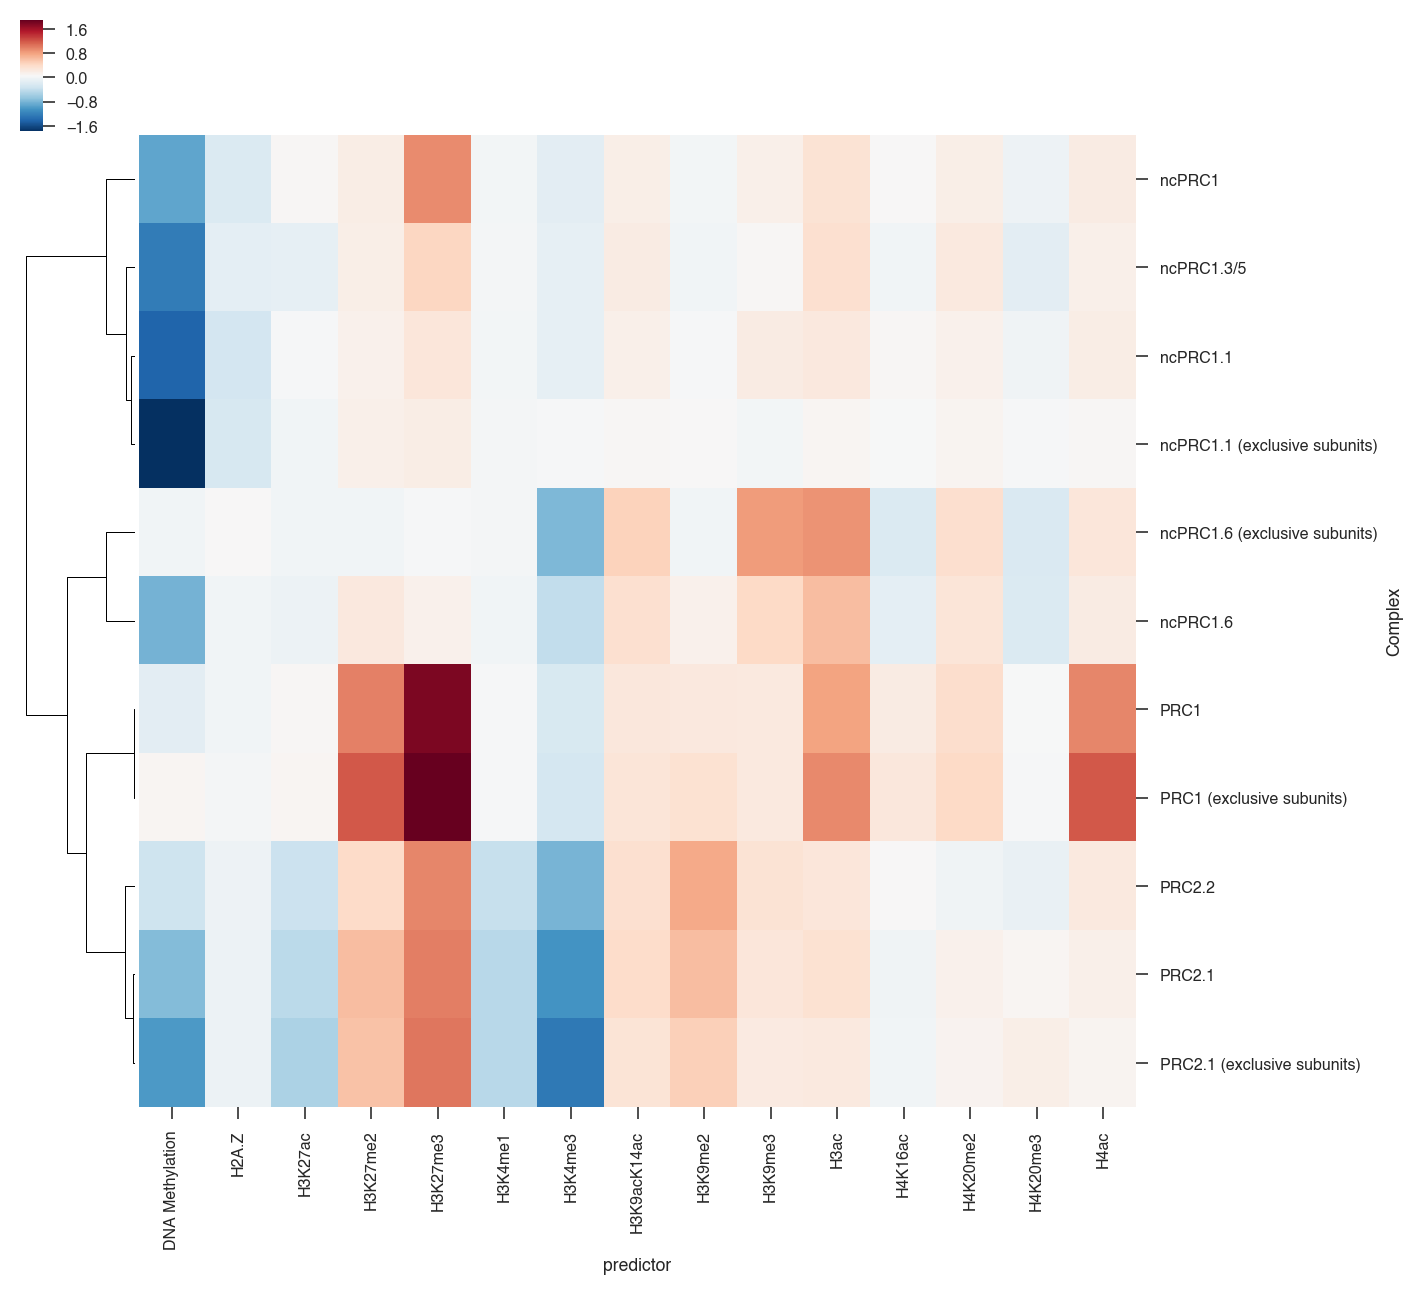

In [6]:
sns.clustermap(enrichment_complexes['mean_logFC'].unstack('predictor').loc[complexes].fillna(0), 
               cmap='RdBu_r', col_cluster=False, metric='cosine', method='complete')

In [7]:
import matplotlib.gridspec as gridspec
from scipy.cluster import hierarchy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def draw_heatmap(data, fig_width=8, height_per_row=0.3):
    data = data.copy()
    
    n_complexes = len(data.reset_index()['Complex'].unique())

    data['annot'] = ''

    data.loc[data['FDR'] <= 0.01, 'annot'] = '*'
    data.loc[data['FDR'] <= 0.001, 'annot'] = '**'
    data.loc[data['FDR'] <= 0.0001, 'annot'] = '***'


    matrix = data['mean_logFC'].unstack('predictor')

    matrix_without_na = matrix.fillna(0)
    mask = matrix.isnull()
    annot = data['annot'].unstack('predictor')


    cmap = 'RdBu_r'
    vmin = -2.0
    vmax = 2.0

    linkage = hierarchy.linkage(matrix_without_na, method='complete', metric='cosine', optimal_ordering=True)
    row_order = matrix.index[hierarchy.dendrogram(linkage, no_plot=True)['leaves']]


    matrix = matrix.loc[row_order]
    matrix_without_na = matrix_without_na.loc[row_order]
    mask = mask.loc[row_order]
    annot = annot.loc[row_order]

    legend_row_count = 2


    fig = plt.figure(figsize=(fig_width, (n_complexes+legend_row_count)*height_per_row+1))

    n_groups = len(GROUPED_ORDER)

    spec = gridspec.GridSpec(ncols=(n_groups + 1),
                             nrows=2, 
                             figure=fig,
                             width_ratios=[4] + [len(x) for x in GROUPED_ORDER],
                             height_ratios=(n_complexes, legend_row_count))


    ax_dendrogram = fig.add_subplot(spec[0, 0])

    hierarchy.dendrogram(linkage, ax=ax_dendrogram, link_color_func=lambda x: 'black', orientation='left')
    ax_dendrogram.grid(False)


    ax_dendrogram.invert_yaxis()
    ax_dendrogram.xaxis.tick_top()
    ax_dendrogram.xaxis.set_tick_params(length=0)
    ax_dendrogram.xaxis.set_visible(False)
    ax_dendrogram.yaxis.set_visible(False)

    for spine in ax_dendrogram.spines:
        ax_dendrogram.spines[spine].set_visible(False)

    ax_colormap_area = fig.add_subplot(spec[1, 1:4])
    ax_colormap_area.set_visible(False)
    ax_colormap = inset_axes(ax_colormap_area,
                             width="100%",  
                             height="40%",
                             loc='upper center')

    ax=None

    for i, predictor_subgroup in enumerate(GROUPED_ORDER):
        col_number = i+1
        ax = fig.add_subplot(spec[0, col_number], sharey=ax)

        cbar_kws = dict(cbar=False)
        if i == 0:
            cbar_kws = dict(cbar_ax=ax_colormap, 
                            cbar_kws=dict(orientation='horizontal', label='Mean effect of chromatin feature'), 
                            cbar=True)


        sns.heatmap(matrix_without_na[predictor_subgroup], 
    #                 mask=mask[predictor_subgroup],
                    annot=annot[predictor_subgroup].fillna('?'),
                    ax=ax, 
                    fmt='s',
                    cmap=cmap, vmin=vmin, vmax=vmax,
                    linewidth=1.0, 
                    linecolor='white',
                    yticklabels=1, **cbar_kws)

        ax.set_ylabel('')
        ax.set_xlabel('')

        ax.xaxis.tick_top()
        ax.yaxis.tick_right()

        ax.xaxis.set_tick_params(length=0, rotation=90)
        ax.yaxis.set_tick_params(length=0, rotation=0)

        if i < len(GROUPED_ORDER) - 1:

            for tick in ax.get_yticklabels():
                tick.set_visible(False)



    ax_legend = fig.add_subplot(spec[1, 5:])
    ax_colormap.xaxis.set_ticks([-2.0, -1.0, 0.0, 1.0, 2.0])
    ax_colormap.xaxis.set_tick_params(length=0)

    ax_legend.text(0.01, 0.99, '***\n**\n*\n?', ha='left', va='top')
    ax_legend.text(0.15, 0.99, 'FDR $\leq$ 0.0001\nFDR $\leq$ 0.001\nFDR $\leq$ 0.01\ncould not be estimated', ha='left', va='top')
    ax_legend.grid(False)
    ax_legend.xaxis.set_visible(False)
    ax_legend.yaxis.set_visible(False)

    for spine in ax_legend.spines:
        ax_legend.spines[spine].set_visible(False)
    
    plt.tight_layout(w_pad=0.2, h_pad=0.4)
    return fig

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


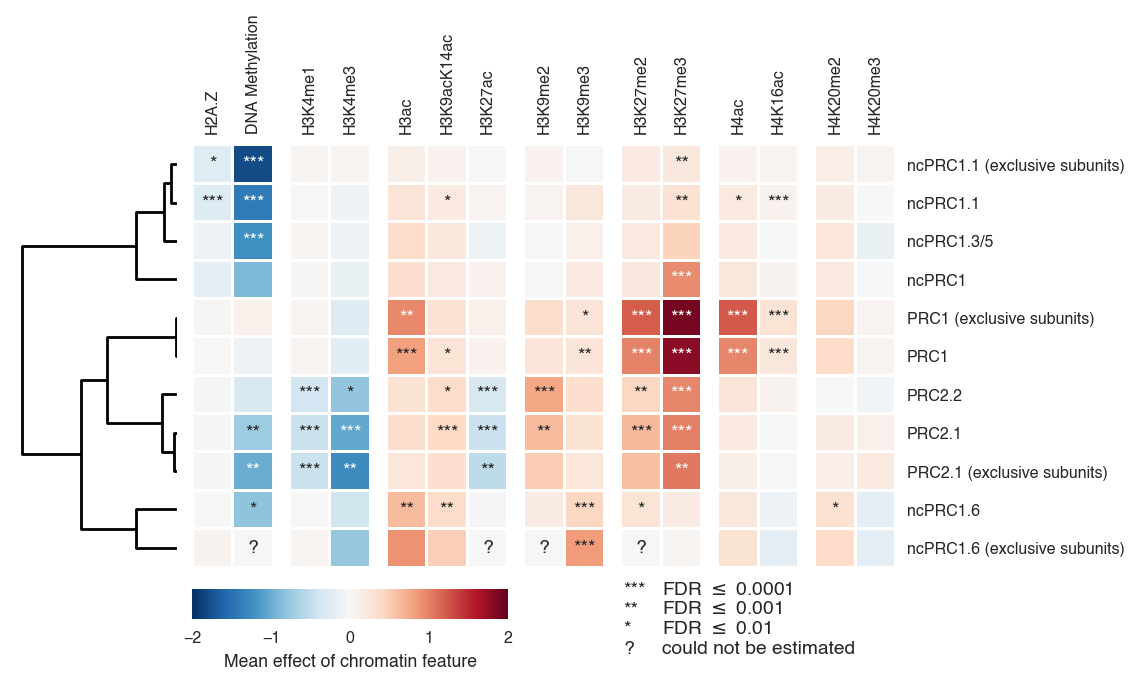

In [8]:
data = enrichment_complexes.loc(axis=0)[:, complexes].copy()

draw_heatmap(data)
plt.savefig(os.path.join(OUTPUT_DIRECTORY, 'heatmap-complexes-prc-only.pdf'), bbox_inches='tight')

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


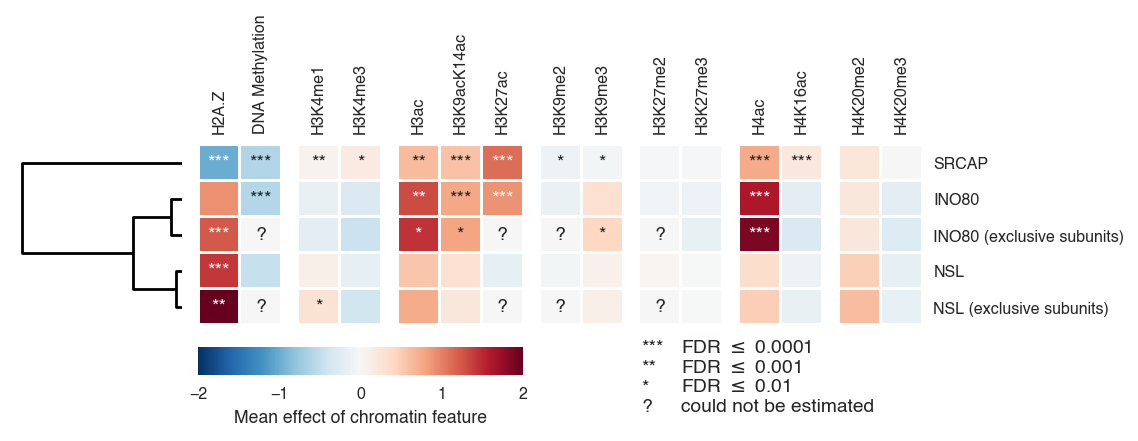

In [9]:
_complexes = enrichment_complexes.reset_index()['Complex'].unique()
_complexes = ['INO80', 'INO80 (exclusive subunits)', 
              'SRCAP', 'SRCAP (exclusive subunits)', 
              'NSL', 'NSL (exclusive subunits)']

data = enrichment_complexes.loc(axis=0)[:, _complexes].copy()
draw_heatmap(data)
plt.savefig(os.path.join(OUTPUT_DIRECTORY, 'heatmap-srcap-ino80-nsl.pdf'), 
            bbox_inches='tight')

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


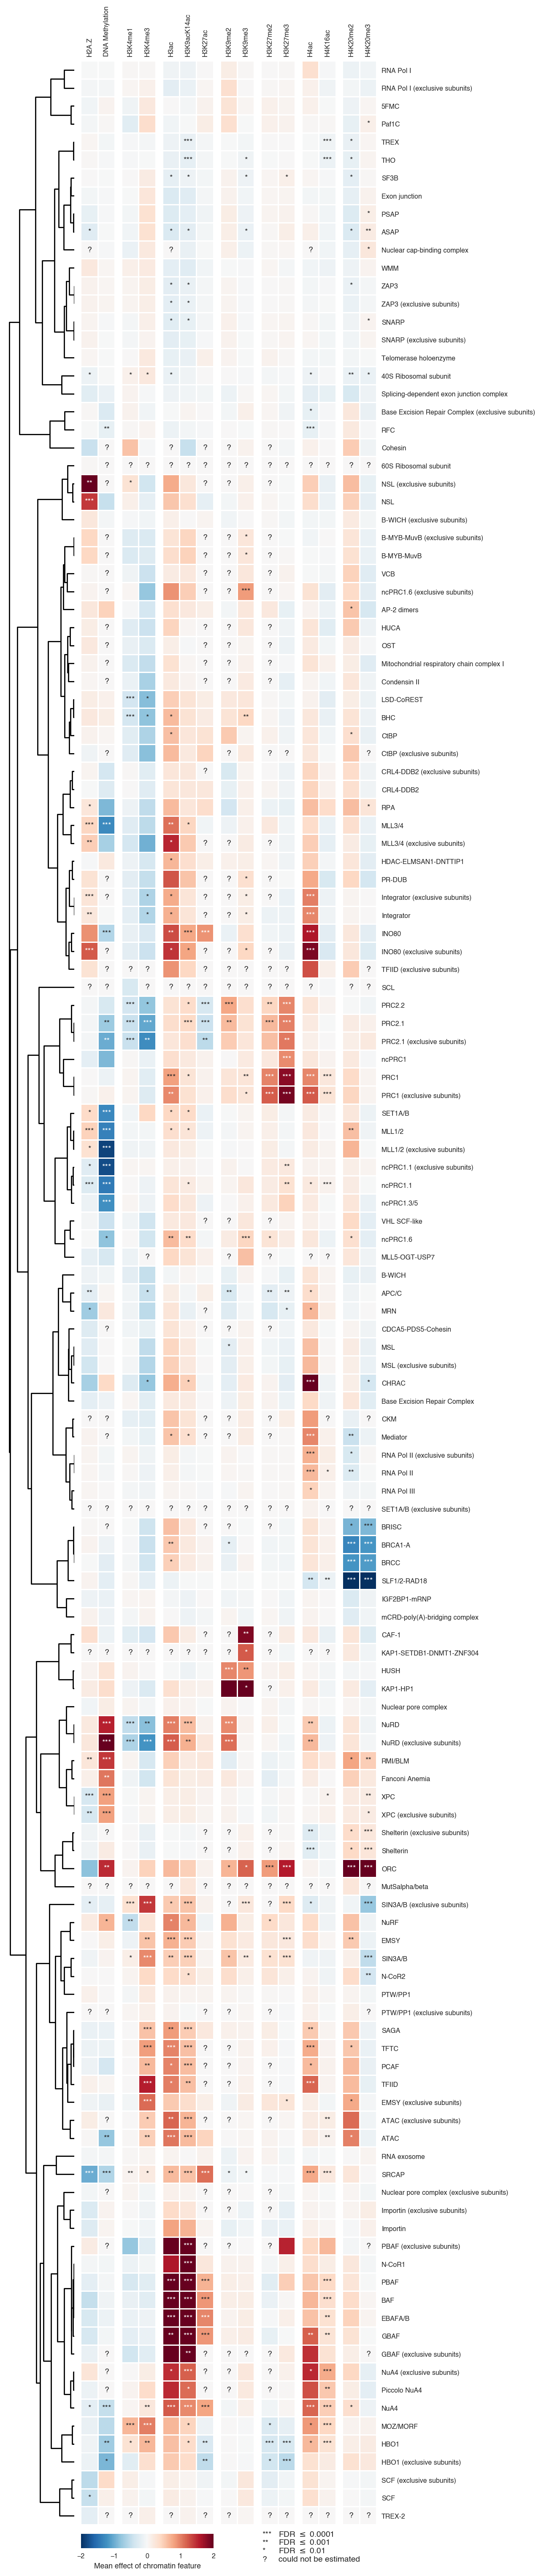

In [10]:
draw_heatmap(enrichment_complexes, fig_width=9)
plt.savefig(os.path.join(OUTPUT_DIRECTORY, 'heatmap-complexes.pdf'), 
            bbox_inches='tight')

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


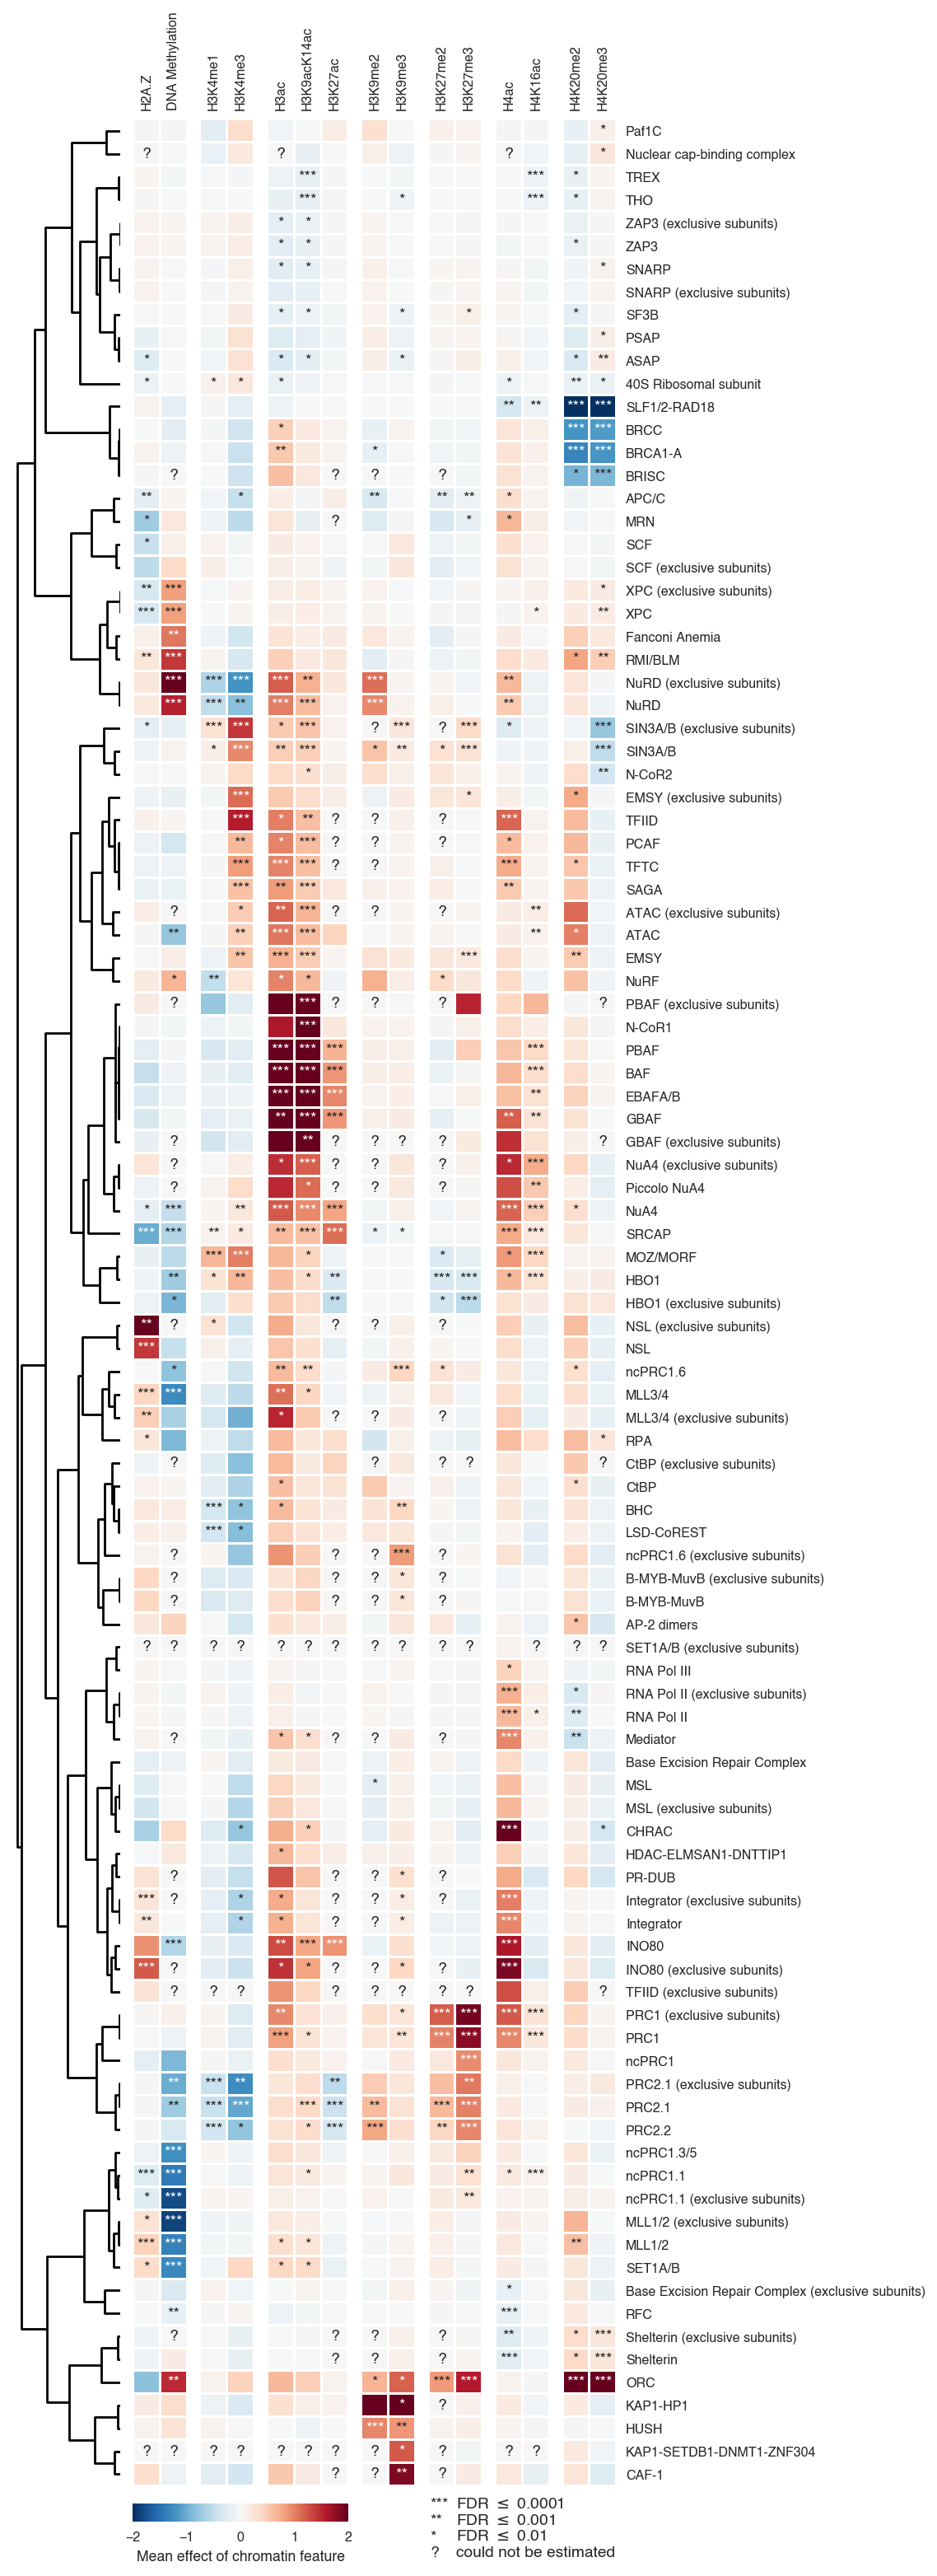

In [11]:
# The main idea is to filter keeping only complexes significant in at least one experiment.
# The complicated logic just tries to make sure to include both complex and complex (exclusive subunits)
# when one or the other is significant..

significant_complexes = set()

for complex_ in enrichment_complexes.reset_index()['Complex'].unique():
    complex_exclusive_subunits = f'{complex_} (exclusive subunits)'
    
    if complex_.endswith(' (exclusive subunits)'):
        # Strip (exclusive subunits)
        complex_ = complex_[:-len(' (exclusive subunits)')]
        complex_exclusive_subunits = f'{complex_} (exclusive subunits)'
        
    ec = enrichment_complexes.reset_index()
    ec = ec[ec['Complex'].isin([complex_, complex_exclusive_subunits])]
    
    if ec['significant'].any():
        
        if complex_ in ec['Complex'].unique():
            significant_complexes.add(complex_)
        if complex_exclusive_subunits in ec['Complex'].unique():
            significant_complexes.add(complex_exclusive_subunits)
        
draw_heatmap(enrichment_complexes.loc(axis=0)[:, significant_complexes],
             height_per_row=0.2)
plt.savefig(os.path.join(OUTPUT_DIRECTORY, 'heatmap-complexes-significant-only.pdf'), bbox_inches='tight')

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


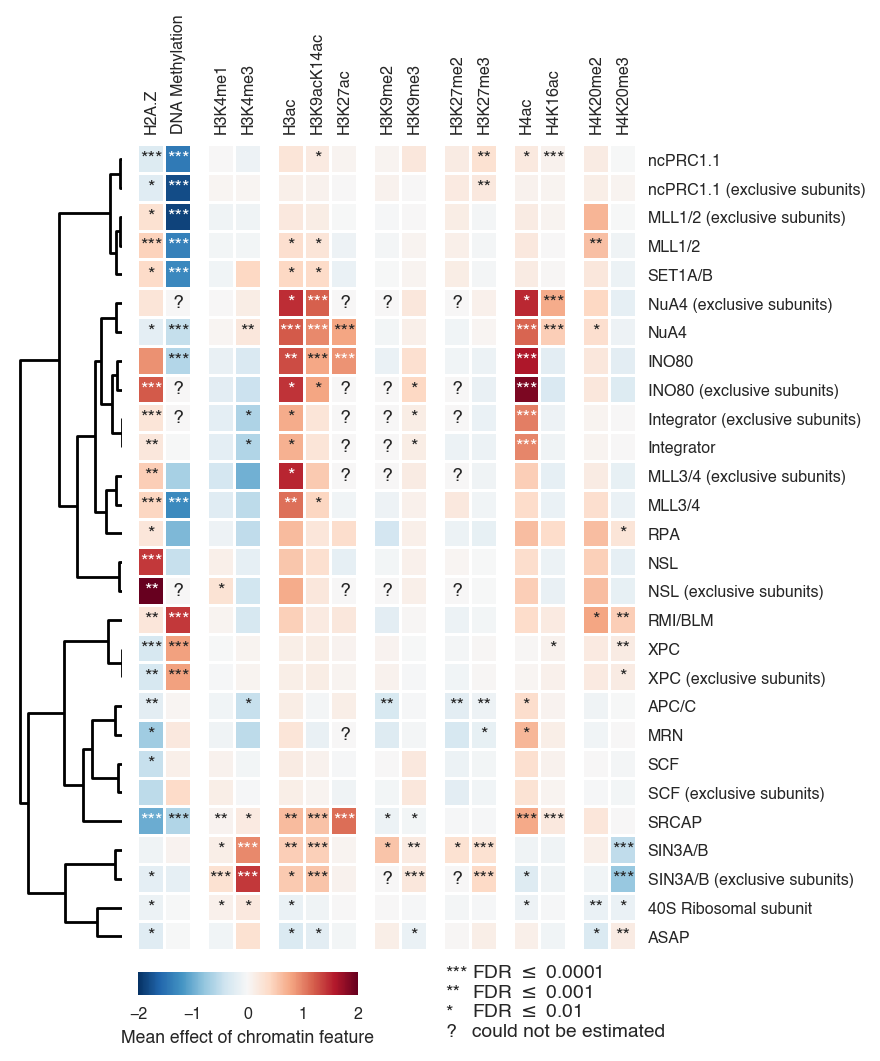

In [18]:
# The main idea is to filter keeping only complexes significant for H2A.Z
significant_complexes = set()
ptm = 'H2A.Z'
for complex_ in enrichment_complexes.reset_index()['Complex'].unique():
    complex_exclusive_subunits = f'{complex_} (exclusive subunits)'
    
    if complex_.endswith(' (exclusive subunits)'):
        # Strip (exclusive subunits)
        complex_ = complex_[:-len(' (exclusive subunits)')]
        complex_exclusive_subunits = f'{complex_} (exclusive subunits)'
        
    ec = enrichment_complexes.loc[ptm].reset_index()
    ec = ec[ec['Complex'].isin([complex_, complex_exclusive_subunits])]
    
    if ec['significant'].any():
        
        if complex_ in ec['Complex'].unique():
            significant_complexes.add(complex_)
        if complex_exclusive_subunits in ec['Complex'].unique():
            significant_complexes.add(complex_exclusive_subunits)
        
draw_heatmap(enrichment_complexes.loc(axis=0)[:, significant_complexes],
             fig_width=6.2,
             height_per_row=0.22)
plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'heatmap-complexes-significant-only-{ptm}.pdf'), bbox_inches='tight')